<a href="https://colab.research.google.com/github/CarFer95/ProyectoCancelacionesPedido/blob/main/ProyectoCancelaciones_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.- Montar Drive

In [ ]:
#1. Montar Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2.- Verificar que la carpeta SCRUM existe ---

In [ ]:
# --- 2. Verificar que la carpeta SCRUM existe ---
import os

base_path = "/content/drive/MyDrive/MAESTRIA/"
print("Contenido de MyDrive:")
print(os.listdir(base_path))

scrum_path = os.path.join(base_path, "MODULO_XIII")
print("\nContenido de SCRUM:")
print(os.listdir(scrum_path))


Contenido de MyDrive:
['MODULO_XIII', 'MODULO_XI']

Contenido de SCRUM:
['V2_simulacion_mensual.ipynb', 'olist_geolocation_dataset.csv', 'olist_customers_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_items_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'master_table_olist_is_canceled.csv', 'prueba00', 'EDA_V2.ipynb', 'master_table_dictionary.csv', 'EDA_INICIAL.ipynb', 'trabajo practico1.ipynb', 'exp01', 'EDA_VIERNES', 'orders_extended_for_eda.csv', 'V2.ipynb']


# 3.- Importar librerías

In [ ]:
# --- 3. Importar librerías ---
import pandas as pd
import numpy as np

# Ruta base donde están tus CSV
ruta_base = "/content/drive/MyDrive/MAESTRIA/MODULO_XIII/"
ruta_orders = ruta_base + "/olist_orders_dataset.csv"

# --- 4. Cargar solo la tabla de órdenes ---
orders = pd.read_csv(
    ruta_orders,
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ]
)

print("Shape orders:", orders.shape)
print("\nColumnas:")
print(orders.columns.tolist())

print("\nTipos de datos:")
print(orders.dtypes)

print("\nDistribución de order_status:")
print(orders["order_status"].value_counts(dropna=False))

print("\nProporción de nulos en columnas de fecha:")
print(orders[[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]].isna().mean().round(3))


Shape orders: (99441, 8)

Columnas:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Tipos de datos:
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Distribución de order_status:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Proporción de nulos en columnas de fecha:
order_purchase_timestamp         0.000
order_approved_at                0.002

# 4.- Target Anterior y Actual

In [ ]:
import numpy as np
import pandas as pd

# 1) Target estricto (lo que ya usábamos)
orders["is_canceled_strict"] = (orders["order_status"] == "canceled").astype(int)

# 2) Preparar componentes del target extendido

# 2.1. Canceled explícito
cond_canceled = orders["order_status"] == "canceled"

# 2.2. Unavailable (pedido no completado por stock/pago)
cond_unavailable = orders["order_status"] == "unavailable"

# 2.3. Pedidos "colgados": created / processing sin entrega después de cierto tiempo
# Tomamos como referencia la última fecha de compra del dataset
last_purchase = orders["order_purchase_timestamp"].max()
umbral_fecha = last_purchase - pd.Timedelta(days=30)

cond_pending_old = (
    orders["order_status"].isin(["created", "processing"])
    & orders["order_delivered_customer_date"].isna()
    & (orders["order_purchase_timestamp"] < umbral_fecha)
)

# 3) Construir el target extendido
orders["order_canceled_extended"] = np.where(
    cond_canceled | cond_unavailable | cond_pending_old,
    1,
    0
)

# 4) Resumen de tasas
print("Tasa estricta (solo 'canceled'):", round(orders["is_canceled_strict"].mean(), 4))
print("Tasa extendida:", round(orders["order_canceled_extended"].mean(), 4))

print("\nConteo por valor del target extendido:")
print(orders["order_canceled_extended"].value_counts())

# 5) Tabla cruzada para ver de dónde vienen los '1' del extendido
print("\nCruce order_status vs order_canceled_extended:")
print(pd.crosstab(orders["order_status"], orders["order_canceled_extended"]))


Tasa estricta (solo 'canceled'): 0.0063
Tasa extendida: 0.0155

Conteo por valor del target extendido:
order_canceled_extended
0    97901
1     1540
Name: count, dtype: int64

Cruce order_status vs order_canceled_extended:
order_canceled_extended      0    1
order_status                       
approved                     2    0
canceled                     0  625
created                      0    5
delivered                96478    0
invoiced                   314    0
processing                   0  301
shipped                   1107    0
unavailable                  0  609


In [ ]:
import os
import pandas as pd

ruta_base = "/content/drive/MyDrive/MAESTRIA/MODULO_XIII/"

# Ver para estar seguros qué archivos hay
print("Archivos en SCRUM:")
print(os.listdir(ruta_base))

# Cargar las demás tablas
ruta_items = ruta_base + "/olist_order_items_dataset.csv"
ruta_payments = ruta_base + "/olist_order_payments_dataset.csv"
ruta_customers = ruta_base + "/olist_customers_dataset.csv"
ruta_sellers = ruta_base + "/olist_sellers_dataset.csv"
ruta_products = ruta_base + "/olist_products_dataset.csv"
ruta_cat_trad = ruta_base + "/product_category_name_translation.csv"

order_items = pd.read_csv(ruta_items)
order_payments = pd.read_csv(ruta_payments)
customers = pd.read_csv(ruta_customers)
sellers = pd.read_csv(ruta_sellers)
products = pd.read_csv(ruta_products)
cat_trad = pd.read_csv(ruta_cat_trad)

print("\nShapes:")
print("order_items:", order_items.shape)
print("order_payments:", order_payments.shape)
print("customers:", customers.shape)
print("sellers:", sellers.shape)
print("products:", products.shape)
print("cat_trad:", cat_trad.shape)


Archivos en SCRUM:
['V2_simulacion_mensual.ipynb', 'olist_geolocation_dataset.csv', 'olist_customers_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_items_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'master_table_olist_is_canceled.csv', 'prueba00', 'EDA_V2.ipynb', 'master_table_dictionary.csv', 'EDA_INICIAL.ipynb', 'trabajo practico1.ipynb', 'exp01', 'EDA_VIERNES', 'orders_extended_for_eda.csv', 'V2.ipynb']

Shapes:
order_items: (112650, 7)
order_payments: (103886, 5)
customers: (99441, 5)
sellers: (3095, 4)
products: (32951, 9)
cat_trad: (71, 2)


# 5.- Carga de Tablas

In [ ]:
import pandas as pd
import numpy as np

# --- Helper para sacar la moda de forma segura ---
def moda_safe(series):
    if series.isna().all():
        return np.nan
    m = series.mode()
    if len(m) == 0:
        return np.nan
    return m.iloc[0]

# 1) Unir products con traducción de categorías
products_trad = products.merge(
    cat_trad,
    on="product_category_name",
    how="left"
).rename(columns={
    "product_category_name": "product_category_name_pt",
    "product_category_name_english": "product_category_name_en"
})

print("products_trad columnas:", products_trad.columns.tolist())

# 2) Unir order_items con info de producto (categorías)
order_items_full = order_items.merge(
    products_trad[["product_id", "product_category_name_pt", "product_category_name_en"]],
    on="product_id",
    how="left"
)

print("order_items_full shape:", order_items_full.shape)

# 3) Agregados numéricos por pedido
items_agg = (
    order_items_full
    .groupby("order_id")
    .agg(
        price_sum=("price", "sum"),
        freight_sum=("freight_value", "sum"),
        items_qty=("order_item_id", "count"),
        seller_count=("seller_id", "nunique")
    )
    .reset_index()
)

print("items_agg shape:", items_agg.shape)
print(items_agg.head())

# 4) Categoría principal por pedido (moda)
items_cat = (
    order_items_full
    .groupby("order_id")
    .agg(
        main_category=("product_category_name_pt", moda_safe),
        main_category_en=("product_category_name_en", moda_safe)
    )
    .reset_index()
)

print("\nitems_cat shape:", items_cat.shape)
print(items_cat.head())


products_trad columnas: ['product_id', 'product_category_name_pt', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_en']
order_items_full shape: (112650, 9)
items_agg shape: (98666, 5)
                           order_id  price_sum  freight_sum  items_qty  \
0  00010242fe8c5a6d1ba2dd792cb16214      58.90        13.29          1   
1  00018f77f2f0320c557190d7a144bdd3     239.90        19.93          1   
2  000229ec398224ef6ca0657da4fc703e     199.00        17.87          1   
3  00024acbcdf0a6daa1e931b038114c75      12.99        12.79          1   
4  00042b26cf59d7ce69dfabb4e55b4fd9     199.90        18.14          1   

   seller_count  
0             1  
1             1  
2             1  
3             1  
4             1  

items_cat shape: (98666, 3)
                           order_id       main_category main_category_en
0  00010242fe8c5a6d1ba2dd792c

# 6.- Unir ORDERS + agregados de ITEMS

In [ ]:
# --- Unir ORDERS + agregados de ITEMS ---

orders_items = (
    orders
    .merge(items_agg, on="order_id", how="left")
    .merge(items_cat, on="order_id", how="left")
)

print("Shape orders:", orders.shape)
print("Shape orders_items:", orders_items.shape)

# ¿Cuántos pedidos NO tienen items agregados?
print("\nPedidos sin price_sum (sin items asociados):", orders_items["price_sum"].isna().sum())

# Resumen rápido de las columnas nuevas
cols_nuevas = ["price_sum", "freight_sum", "items_qty", "seller_count", "main_category", "main_category_en"]
print("\nProporción de nulos en columnas de items/categoría:")
print(orders_items[cols_nuevas].isna().mean().round(3))

print("\nEjemplo de filas con y sin items:")
print(orders_items[cols_nuevas + ["order_status", "order_canceled_extended"]].head(10))

Shape orders: (99441, 10)
Shape orders_items: (99441, 16)

Pedidos sin price_sum (sin items asociados): 775

Proporción de nulos en columnas de items/categoría:
price_sum           0.008
freight_sum         0.008
items_qty           0.008
seller_count        0.008
main_category       0.022
main_category_en    0.022
dtype: float64

Ejemplo de filas con y sin items:
   price_sum  freight_sum  items_qty  seller_count          main_category  \
0      29.99         8.72        1.0           1.0  utilidades_domesticas   
1     118.70        22.76        1.0           1.0             perfumaria   
2     159.90        19.22        1.0           1.0             automotivo   
3      45.00        27.20        1.0           1.0               pet_shop   
4      19.90         8.72        1.0           1.0              papelaria   
5     147.90        27.36        1.0           1.0             automotivo   
6      49.90        16.05        1.0           1.0                    NaN   
7      59.99     

# 7.- Agregados de pagos por pedido

In [ ]:
# --- Agregados de pagos por pedido ---

# 1) Agregar pagos por order_id
pay_agg = (
    order_payments
    .groupby("order_id")
    .agg(
        payment_value_sum=("payment_value", "sum"),
        max_installments=("payment_installments", "max"),
        payments_cnt=("payment_sequential", "count"),
        main_payment_type=("payment_type", moda_safe)  # usamos la misma moda_safe de antes
    )
    .reset_index()
)

print("pay_agg shape:", pay_agg.shape)
print(pay_agg.head())

# 2) Unir pagos a la tabla orders_items (que ya tiene el target extendido)
orders_items_pay = orders_items.merge(pay_agg, on="order_id", how="left")

print("\nShape orders_items:", orders_items.shape)
print("Shape orders_items_pay:", orders_items_pay.shape)

print("\nProporción de nulos en columnas de pago:")
cols_pago = ["payment_value_sum", "max_installments", "payments_cnt", "main_payment_type"]
print(orders_items_pay[cols_pago].isna().mean().round(3))

print("\nEjemplo de filas con info de pago:")
print(orders_items_pay[cols_pago + ["order_status", "order_canceled_extended"]].head(10))

pay_agg shape: (99440, 5)
                           order_id  payment_value_sum  max_installments  \
0  00010242fe8c5a6d1ba2dd792cb16214              72.19                 2   
1  00018f77f2f0320c557190d7a144bdd3             259.83                 3   
2  000229ec398224ef6ca0657da4fc703e             216.87                 5   
3  00024acbcdf0a6daa1e931b038114c75              25.78                 2   
4  00042b26cf59d7ce69dfabb4e55b4fd9             218.04                 3   

   payments_cnt main_payment_type  
0             1       credit_card  
1             1       credit_card  
2             1       credit_card  
3             1       credit_card  
4             1       credit_card  

Shape orders_items: (99441, 16)
Shape orders_items_pay: (99441, 20)

Proporción de nulos en columnas de pago:
payment_value_sum    0.0
max_installments     0.0
payments_cnt         0.0
main_payment_type    0.0
dtype: float64

Ejemplo de filas con info de pago:
   payment_value_sum  max_installments 

## 7.1 Unir información de clientes (ubicación del cliente)

In [ ]:
# --- 7.1 Unir información de clientes (ubicación del cliente) ---

orders_full = orders_items_pay.merge(
    customers[["customer_id", "customer_city", "customer_state"]],
    on="customer_id",
    how="left"
)

print("Shape orders_items_pay:", orders_items_pay.shape)
print("Shape orders_full tras customers:", orders_full.shape)

print("\nProporción de nulos en customer_city/state:")
print(orders_full[["customer_city", "customer_state"]].isna().mean().round(3))


# --- 7.2 Construir ubicación del vendedor principal por pedido ---

# Unir order_items_full con sellers para tener ciudad/estado del seller
items_seller = order_items_full.merge(
    sellers[["seller_id", "seller_city", "seller_state"]],
    on="seller_id",
    how="left"
)

print("\nitems_seller shape:", items_seller.shape)

# Agregar por order_id → moda de ciudad y estado del vendedor
seller_by_order = (
    items_seller
    .groupby("order_id")
    .agg(
        main_seller_city=("seller_city", moda_safe),
        main_seller_state=("seller_state", moda_safe)
    )
    .reset_index()
)

print("seller_by_order shape:", seller_by_order.shape)
print(seller_by_order.head())

# Unir vendedor principal a orders_full
orders_full = orders_full.merge(seller_by_order, on="order_id", how="left")

print("\nShape final tras unir seller:", orders_full.shape)

print("\nProporción de nulos en main_seller_city/state:")
print(orders_full[["main_seller_city", "main_seller_state"]].isna().mean().round(3))

# Ver ejemplo de columnas clave
cols_demo = [
    "order_status",
    "order_canceled_extended",
    "price_sum", "freight_sum",
    "payment_value_sum", "main_payment_type",
    "customer_state", "main_seller_state",
    "main_category", "main_category_en"
]
print("\nEjemplo de filas completas:")
print(orders_full[cols_demo].head(10))

Shape orders_items_pay: (99441, 20)
Shape orders_full tras customers: (99441, 22)

Proporción de nulos en customer_city/state:
customer_city     0.0
customer_state    0.0
dtype: float64

items_seller shape: (112650, 11)
seller_by_order shape: (98666, 3)
                           order_id main_seller_city main_seller_state
0  00010242fe8c5a6d1ba2dd792cb16214    volta redonda                SP
1  00018f77f2f0320c557190d7a144bdd3        sao paulo                SP
2  000229ec398224ef6ca0657da4fc703e    borda da mata                MG
3  00024acbcdf0a6daa1e931b038114c75           franca                SP
4  00042b26cf59d7ce69dfabb4e55b4fd9           loanda                PR

Shape final tras unir seller: (99441, 24)

Proporción de nulos en main_seller_city/state:
main_seller_city     0.008
main_seller_state    0.008
dtype: float64

Ejemplo de filas completas:
  order_status  order_canceled_extended  price_sum  freight_sum  \
0    delivered                        0      29.99         8.72 

##8.1 Columnas derivadas

In [ ]:
# --- 8.1 Columnas derivadas ---

# Valor total del pedido (precio + flete)
orders_full["order_total_value"] = orders_full["price_sum"] + orders_full["freight_sum"]

# Año-mes de compra (para análisis temporal)
orders_full["purchase_ym"] = orders_full["order_purchase_timestamp"].dt.to_period("M").astype(str)

print("Columnas actuales en orders_full:")
print(orders_full.columns.tolist())


# --- 8.2 Seleccionar columnas clave para el dataset final ---

cols_final = [
    # Identificación y tiempo
    "order_id",
    "order_status",
    "order_purchase_timestamp",
    "purchase_ym",

    # Targets
    "is_canceled_strict",
    "order_canceled_extended",

    # Montos y estructura de pedido
    "price_sum",
    "freight_sum",
    "order_total_value",
    "items_qty",
    "seller_count",

    # Pagos
    "payment_value_sum",
    "max_installments",
    "payments_cnt",
    "main_payment_type",

    # Ubicación
    "customer_city",
    "customer_state",
    "main_seller_city",
    "main_seller_state",

    # Producto
    "main_category",
    "main_category_en"
]

df_extended = orders_full[cols_final].copy()

print("\nShape df_extended:", df_extended.shape)

# --- 8.3 Chequeos rápidos de calidad ---

print("\nProporción de nulos en df_extended:")
print(df_extended.isna().mean().round(3))

print("\nDistribución de los targets:")
print("is_canceled_strict:")
print(df_extended["is_canceled_strict"].value_counts(normalize=True).round(4))

print("\norder_canceled_extended:")
print(df_extended["order_canceled_extended"].value_counts(normalize=True).round(4))

print("\nVista rápida del dataset final:")
print(df_extended.head())

Columnas actuales en orders_full:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'is_canceled_strict', 'order_canceled_extended', 'price_sum', 'freight_sum', 'items_qty', 'seller_count', 'main_category', 'main_category_en', 'payment_value_sum', 'max_installments', 'payments_cnt', 'main_payment_type', 'customer_city', 'customer_state', 'main_seller_city', 'main_seller_state', 'order_total_value', 'purchase_ym']

Shape df_extended: (99441, 21)

Proporción de nulos en df_extended:
order_id                    0.000
order_status                0.000
order_purchase_timestamp    0.000
purchase_ym                 0.000
is_canceled_strict          0.000
order_canceled_extended     0.000
price_sum                   0.008
freight_sum                 0.008
order_total_value           0.008
items_qty                   0.008
seller_count                0.008

# 9.- Guardar el dataset extendido para EDA y modelos

In [ ]:
# Guardar el dataset extendido para EDA y modelos
out_path = ruta_base + "/orders_extended_for_eda.csv"
df_extended.to_csv(out_path, index=False)

print("Archivo guardado en:", out_path)

Archivo guardado en: /content/drive/MyDrive/MAESTRIA/MODULO_XIII//orders_extended_for_eda.csv


# 10.- Visualización del Target Inicial y Extendido

In [ ]:
import pandas as pd

df = df_extended  # por comodidad

print("Tasa estricta (solo 'canceled'):", df["is_canceled_strict"].mean().round(4))
print("Tasa extendida:", df["order_canceled_extended"].mean().round(4))

print("\nTasa por método de pago - TARGET ESTRICTO:")
print(
    df.groupby("main_payment_type")["is_canceled_strict"]
      .mean()
      .sort_values(ascending=False)
      .round(4)
)

print("\nTasa por método de pago - TARGET EXTENDIDO:")
print(
    df.groupby("main_payment_type")["order_canceled_extended"]
      .mean()
      .sort_values(ascending=False)
      .round(4)
)

Tasa estricta (solo 'canceled'): 0.0063
Tasa extendida: 0.0155

Tasa por método de pago - TARGET ESTRICTO:
main_payment_type
not_defined    1.0000
voucher        0.0401
credit_card    0.0058
boleto         0.0048
debit_card     0.0046
Name: is_canceled_strict, dtype: float64

Tasa por método de pago - TARGET EXTENDIDO:
main_payment_type
not_defined    1.0000
voucher        0.0502
boleto         0.0160
credit_card    0.0145
debit_card     0.0098
Name: order_canceled_extended, dtype: float64


sprint 2

# 11.- Carga del Dataset Extendido y visualización

In [ ]:
import pandas as pd
import numpy as np

# Ruta base (ya la usamos antes)
ruta_base = "/content/drive/MyDrive/MAESTRIA/MODULO_XIII/"
ruta_extended = ruta_base + "/orders_extended_for_eda.csv"

# 1) Cargar dataset extendido
df = pd.read_csv(ruta_extended, parse_dates=["order_purchase_timestamp"])

print("Shape df:", df.shape)
print("Columnas:", df.columns.tolist())

# 2) Definir target extendido
TARGET = "order_canceled_extended"
y = df[TARGET].astype(int)

print("\nDistribución del target extendido:")
print(y.value_counts(normalize=True).round(4))

# 3) Definir features (por ahora usamos todas menos id/fechas/targets)
features_drop = [
    "order_id",
    "order_status",
    "order_purchase_timestamp",
    "is_canceled_strict",
    "order_canceled_extended"
]

X = df.drop(columns=features_drop)

print("\nShape X:", X.shape)
print("Columnas de X:", X.columns.tolist())

Shape df: (99441, 21)
Columnas: ['order_id', 'order_status', 'order_purchase_timestamp', 'purchase_ym', 'is_canceled_strict', 'order_canceled_extended', 'price_sum', 'freight_sum', 'order_total_value', 'items_qty', 'seller_count', 'payment_value_sum', 'max_installments', 'payments_cnt', 'main_payment_type', 'customer_city', 'customer_state', 'main_seller_city', 'main_seller_state', 'main_category', 'main_category_en']

Distribución del target extendido:
order_canceled_extended
0    0.9845
1    0.0155
Name: proportion, dtype: float64

Shape X: (99441, 16)
Columnas de X: ['purchase_ym', 'price_sum', 'freight_sum', 'order_total_value', 'items_qty', 'seller_count', 'payment_value_sum', 'max_installments', 'payments_cnt', 'main_payment_type', 'customer_city', 'customer_state', 'main_seller_city', 'main_seller_state', 'main_category', 'main_category_en']


# 12.- Estrategia de partición temporal supervisada

In [ ]:
# --- SPLIT TEMPORAL DEFINIDO POR EL DOCENTE ---

# Aseguramos formato YYYYMM
df["purchase_ym"] = df["order_purchase_timestamp"].dt.to_period("M").astype(str).str.replace("-", "")

# 19 meses iniciales → Train + Validation
train_months = [
    "201610", "201611", "201612",  # 3 meses 2016
    *[f"2017{str(m).zfill(2)}" for m in range(1, 13)],  # 12 meses 2017
    "201801", "201802", "201803", "201804"  # 4 meses 2018 => total 19 meses
]

# 3 meses de backtest (no se tocan)
backtest_months = ["201805", "201806", "201807"]

# Último mes para examen final
final_test_month = ["201808"]

# Aplicar splits
df_train = df[df["purchase_ym"].isin(train_months)]
df_backtest = df[df["purchase_ym"].isin(backtest_months)]
df_final_test = df[df["purchase_ym"].isin(final_test_month)]

print("Train:", df_train.shape)
print("Backtest:", df_backtest.shape)
print("Final Test:", df_final_test.shape)

# Separar X / y para entrenamiento
X_train = df_train.drop(columns=features_drop)
y_train = df_train[TARGET].astype(int)

X_backtest = df_backtest.drop(columns=features_drop)
y_backtest = df_backtest[TARGET].astype(int)

X_final_test = df_final_test.drop(columns=features_drop)
y_final_test = df_final_test[TARGET].astype(int)  # NO usar hasta el examen


Train: (73573, 21)
Backtest: (19332, 21)
Final Test: (6512, 21)


# 13.- Entrenamiento del modelo

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# --- 3.1 Preprocesador para columnas numéricas ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# --- 3.2 Preprocesador para columnas categóricas ---
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# --- 3.3 ColumnTransformer que aplica cada bloque donde corresponde ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# --- 3.4 Pipeline completo: preprocesamiento + modelo ---
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs"
    ))
])

print("Pipeline definido. Ahora entrenamos el modelo...")

# --- 3.5 Entrenar el pipeline ---
clf.fit(X_train, y_train)

print("Entrenamiento completado.")

Pipeline definido. Ahora entrenamos el modelo...
Entrenamiento completado.


# 14.- Evaluacion del BackTest

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score

# 4.1 Predicciones
y_pred = clf.predict(X_backtest)
y_proba = clf.predict_proba(X_backtest)[:, 1]

# 4.2 Métricas principales
rec = recall_score(y_backtest, y_pred)
f1 = f1_score(y_backtest, y_pred)
auc = roc_auc_score(y_backtest, y_proba)
gini = 2 * auc - 1

print("MÉTRICAS EN TEST (target extendido)")
print("-----------------------------------")
print(f"Recall:   {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC:  {auc:.4f}")
print(f"Gini:     {gini:.4f}")

# 4.3 Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_backtest, y_pred))

# 4.4 Reporte de clasificación (opcional, pero útil)
print("\nReporte de clasificación:")
print(classification_report(y_backtest, y_pred, digits=4))

MÉTRICAS EN TEST (target extendido)
-----------------------------------
Recall:   0.5781
F1-score: 0.0360
ROC-AUC:  0.7320
Gini:     0.4639

Matriz de confusión:
[[15294  3910]
 [   54    74]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9965    0.7964    0.8853     19204
           1     0.0186    0.5781    0.0360       128

    accuracy                         0.7950     19332
   macro avg     0.5075    0.6873    0.4606     19332
weighted avg     0.9900    0.7950    0.8797     19332



In [ ]:
# --- 6. Evaluación en BACKTEST (201805–201807) ---

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\nEvaluando desempeño en BACKTEST (3 meses nunca vistos)...")

y_pred_bt = clf.predict(X_backtest)
y_proba_bt = clf.predict_proba(X_backtest)[:, 1]

acc  = accuracy_score(y_backtest, y_pred_bt)
prec = precision_score(y_backtest, y_pred_bt)
rec  = recall_score(y_backtest, y_pred_bt)
f1   = f1_score(y_backtest, y_pred_bt)
auc  = roc_auc_score(y_backtest, y_proba_bt)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")



Evaluando desempeño en BACKTEST (3 meses nunca vistos)...
Accuracy:  0.7950
Precision: 0.0186
Recall:    0.5781
F1-score:  0.0360
AUC-ROC:   0.7320


para presentación

# 15.- Graficas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

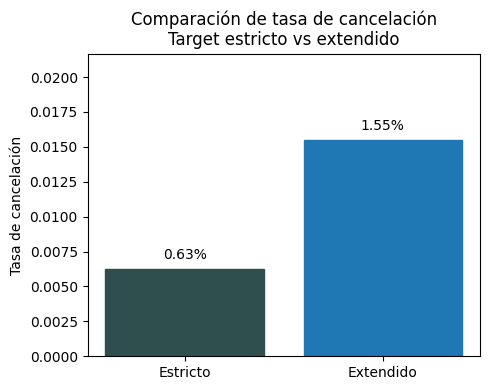

In [ ]:
# 1) Distribución global del target estricto vs extendido

strict_rate = df_extended["is_canceled_strict"].mean()
ext_rate = df_extended["order_canceled_extended"].mean()

labels = ["Estricto", "Extendido"]
values = [strict_rate, ext_rate]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, values)

# Colores ejecutivos
bars[0].set_color("#2F4F4F")  # gris oscuro
bars[1].set_color("#1F77B4")  # azul ejecutivo

plt.ylabel("Tasa de cancelación")
plt.title("Comparación de tasa de cancelación\nTarget estricto vs extendido")
plt.ylim(0, max(values) * 1.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.0005, f"{v:.2%}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

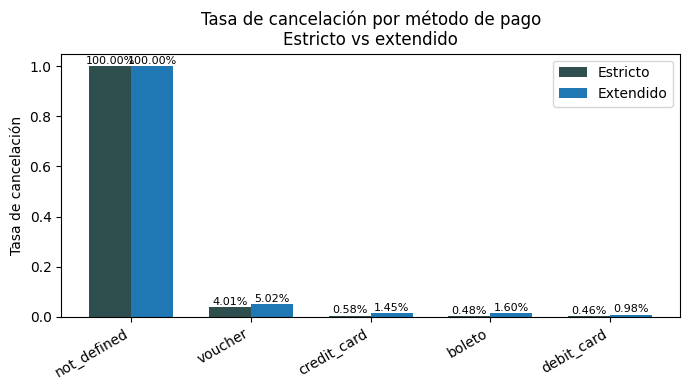

In [ ]:
# 2) Tasa de cancelación por método de pago (estricto vs extendido)

strict_by_pay = (
    df_extended.groupby("main_payment_type")["is_canceled_strict"]
    .mean()
    .sort_values(ascending=False)
)

ext_by_pay = (
    df_extended.groupby("main_payment_type")["order_canceled_extended"]
    .mean()
    .reindex(strict_by_pay.index)
)

labels = strict_by_pay.index.tolist()
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 4))
rects1 = plt.bar(x - width/2, strict_by_pay.values, width, label="Estricto", color="#2F4F4F")
rects2 = plt.bar(x + width/2, ext_by_pay.values, width, label="Extendido", color="#1F77B4")

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Tasa de cancelación")
plt.title("Tasa de cancelación por método de pago\nEstricto vs extendido")
plt.legend()

# --- CORRECCIÓN AQUÍ ---
# Convertimos cada BarContainer en lista de patches con list()
for rect in list(rects1) + list(rects2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + 0.0005,
             f"{height:.2%}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

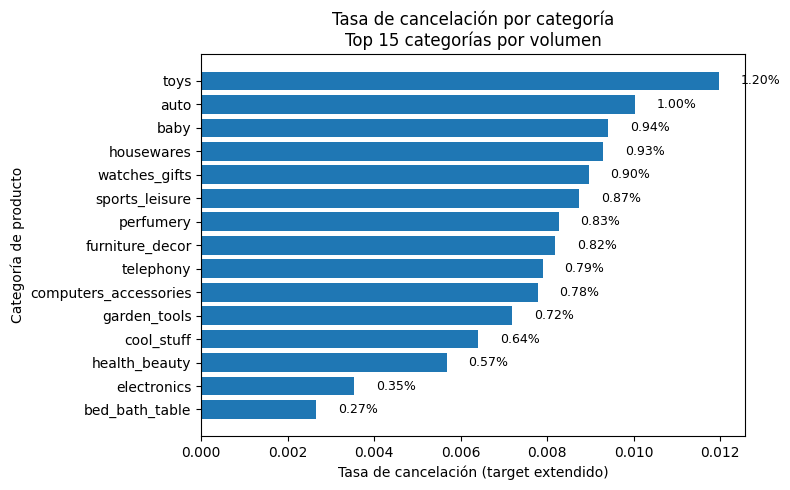

In [ ]:
# 3) Tasa de cancelación por categoría de producto (Top 15 por volumen)

# Agrupamos por categoría en inglés
cat_stats = (
    df_extended.groupby("main_category_en")["order_canceled_extended"]
    .agg(cancel_rate="mean", n_orders="count")
    .reset_index()
)

# Nos quedamos con las 15 categorías con más pedidos
top_cats = (
    cat_stats.sort_values("n_orders", ascending=False)
    .head(15)
    .sort_values("cancel_rate", ascending=True)  # ordenamos por tasa para el gráfico
)

plt.figure(figsize=(8, 5))
bars = plt.barh(
    top_cats["main_category_en"].astype(str),
    top_cats["cancel_rate"],
    color="#1F77B4"
)

plt.xlabel("Tasa de cancelación (target extendido)")
plt.ylabel("Categoría de producto")
plt.title("Tasa de cancelación por categoría\nTop 15 categorías por volumen")

# Etiquetas de porcentaje al final de cada barra
for i, v in enumerate(top_cats["cancel_rate"]):
    plt.text(v + 0.0005, i, f"{v:.2%}", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()

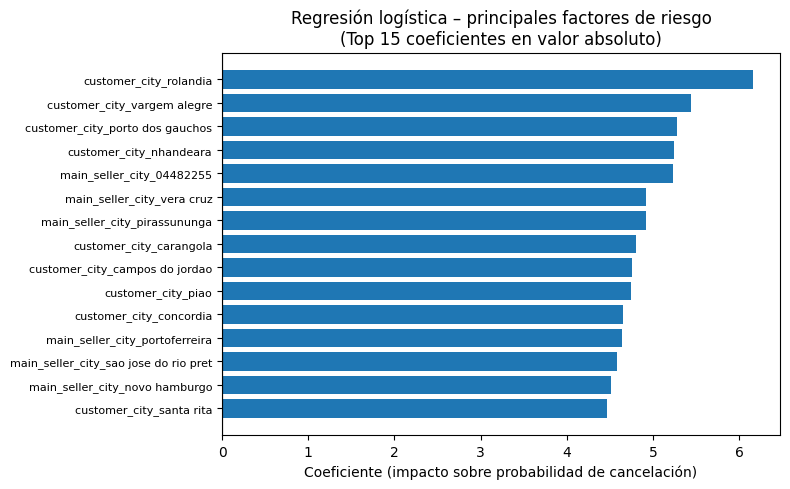

In [ ]:
# 4) "Importancia" de features vía coeficientes de la regresión logística

# Recuperar modelo y preprocesador desde el pipeline
model = clf.named_steps["model"]
preprocessor = clf.named_steps["preprocessor"]

# 4.1 Nombres de las columnas de salida

# Numéricas (se mantienen los mismos nombres)
num_features_out = numeric_cols

# Categóricas: nombres después del OneHotEncoder
cat_transformer = preprocessor.named_transformers_["cat"]
ohe = cat_transformer.named_steps["onehot"]
cat_features_out = ohe.get_feature_names_out(categorical_cols)

# Concatenamos todas las features
feature_names = np.concatenate([num_features_out, cat_features_out])

# 4.2 Coeficientes del modelo
coefs = model.coef_.ravel()

# 4.3 Seleccionar top 15 por valor absoluto
abs_coefs = np.abs(coefs)
idx_sorted = np.argsort(abs_coefs)[-15:]  # índices de los 15 más grandes

top_features = feature_names[idx_sorted]
top_coefs = coefs[idx_sorted]

# 4.4 Gráfico
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(top_features))

colors = ["#1F77B4" if c > 0 else "#B22222" for c in top_coefs]  # azul = aumenta riesgo, rojo = reduce

plt.barh(y_pos, top_coefs, color=colors)
plt.yticks(y_pos, top_features, fontsize=8)
plt.xlabel("Coeficiente (impacto sobre probabilidad de cancelación)")
plt.title("Regresión logística – principales factores de riesgo\n(Top 15 coeficientes en valor absoluto)")
plt.axvline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()


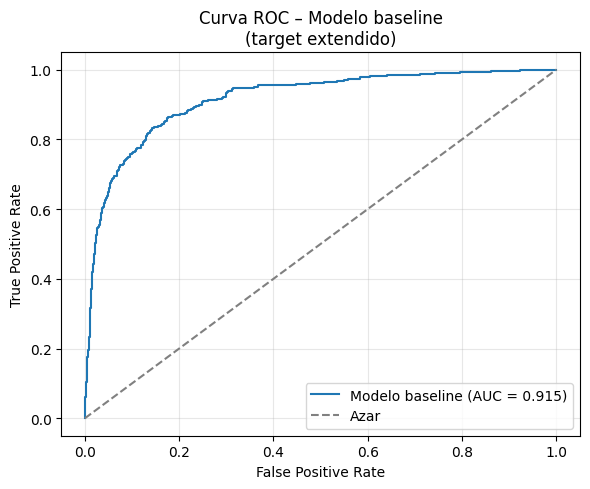

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilidades predichas para la clase 1 (cancelado)
y_proba = clf.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Modelo baseline (AUC = {auc:.3f})", color="#1F77B4")
plt.plot([0, 1], [0, 1], "--", color="#808080", label="Azar")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Modelo baseline\n(target extendido)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


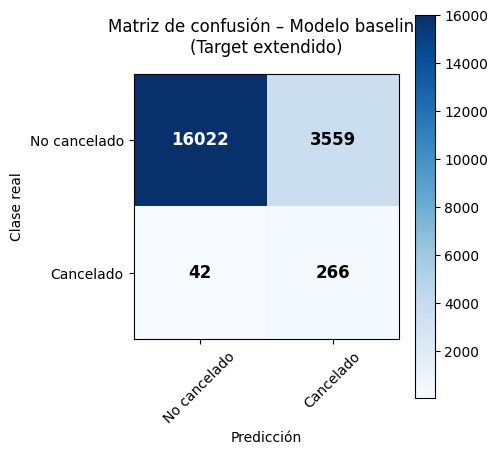

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Matriz de confusión – Modelo baseline\n(Target extendido)", fontsize=12, pad=15)
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No cancelado", "Cancelado"], rotation=45)
plt.yticks(tick_marks, ["No cancelado", "Cancelado"])

# Dibujar líneas de cuadrícula para separar celdas
plt.grid(False)

# Texto dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i,
            format(cm[i, j], "d"),
            ha="center", va="center",
            fontsize=12,
            fontweight="bold",
            color="white" if cm[i, j] > cm.max() / 2 else "black"
        )

plt.ylabel("Clase real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


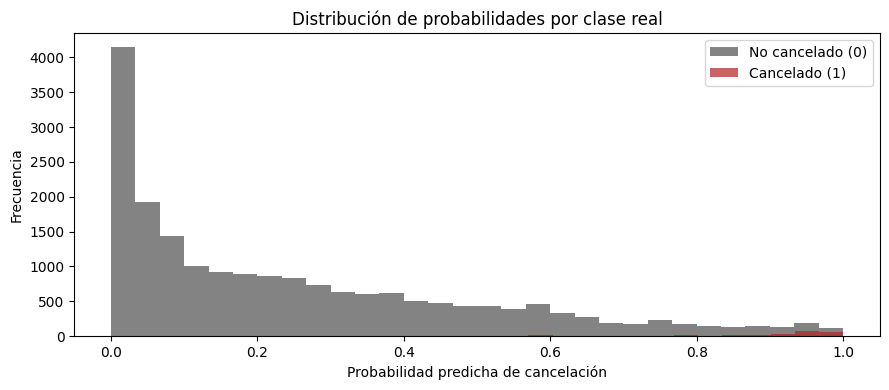

In [ ]:
# 7) Distribución de probabilidades predichas – versión mejorada

y_proba = clf.predict_proba(X_test)[:, 1]

proba_pos = y_proba[y_test == 1]
proba_neg = y_proba[y_test == 0]

plt.figure(figsize=(9, 4))
plt.hist(proba_neg, bins=30, alpha=0.7, label="No cancelado (0)", color="#4F4F4F")
plt.hist(proba_pos, bins=30, alpha=0.7, label="Cancelado (1)", color="#B22222")

plt.xlabel("Probabilidad predicha de cancelación")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades por clase real", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


# 16.- Simulación de incorporación mensual de nuevos datos

En esta sección simulamos el escenario de **producción**, donde cada mes llegan nuevos pedidos
y el modelo ya entrenado (`clf`) se usa para:

- Procesar los datos con el mismo *pipeline* de preprocesamiento.
- Predecir la probabilidad de cancelación de cada pedido del mes.
- Calcular métricas por mes para monitorear el desempeño del modelo en el tiempo.

La clave es que **no reentrenamos** el modelo en cada mes; solo lo usamos para predecir
sobre los nuevos datos, tal como haríamos en un entorno real de negocio.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def simular_nuevos_datos_mensuales(
    df_base,
    pipeline,
    target_col,
    date_col="order_purchase_timestamp",
    features_drop=None
):
    """
    Simula la incorporación mensual de nuevos datos usando un modelo ya entrenado.
    """
    df_sim = df_base.copy()

    # Aseguramos año-mes
    if "purchase_ym" not in df_sim.columns:
        df_sim["purchase_ym"] = df_sim[date_col].dt.to_period("M").astype(str)

    if features_drop is None:
        # Usa la lista global del notebook
        # (en la práctica se pasa por parámetro: features_drop=features_drop)
        features_drop_local = []
    else:
        features_drop_local = list(features_drop)

    cols_drop = features_drop_local + [target_col]

    meses = sorted(df_sim["purchase_ym"].unique())
    resultados = []

    for m in meses:
        df_mes = df_sim[df_sim["purchase_ym"] == m].copy()
        if df_mes.empty:
            continue

        X_mes = df_mes.drop(columns=cols_drop)
        y_mes = df_mes[target_col].astype(int)

        y_pred = pipeline.predict(X_mes)

        try:
            acc = accuracy_score(y_mes, y_pred)
            prec = precision_score(y_mes, y_pred, zero_division=0)
            rec = recall_score(y_mes, y_pred, zero_division=0)
            f1 = f1_score(y_mes, y_pred, zero_division=0)
        except Exception:
            acc = prec = rec = f1 = np.nan

        resultados.append({
            "purchase_ym": m,
            "n_pedidos_mes": len(df_mes),
            "cancel_rate_real": y_mes.mean(),
            "cancel_rate_predicha": (y_pred == 1).mean(),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })

    return pd.DataFrame(resultados)

In [ ]:
monitor_mensual = simular_nuevos_datos_mensuales(
    df_base=df,
    pipeline=clf,
    target_col=TARGET,
    date_col="order_purchase_timestamp",
    features_drop=features_drop
)

print("Evolución de métricas por mes:")
display(monitor_mensual.head())


Evolución de métricas por mes:


,purchase_ym,n_pedidos_mes,cancel_rate_real,cancel_rate_predicha,accuracy,precision,recall,f1
0,201609,4,0.500000,0.250000,0.750000,1.000000,0.500000,0.666667
1,201610,324,0.101852,0.700617,0.395062,0.140969,0.969697,0.246154
2,201612,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,201701,800,0.027500,0.183750,0.841250,0.142857,0.954545,0.248521
4,201702,1780,0.052809,0.407865,0.642697,0.126722,0.978723,0.224390


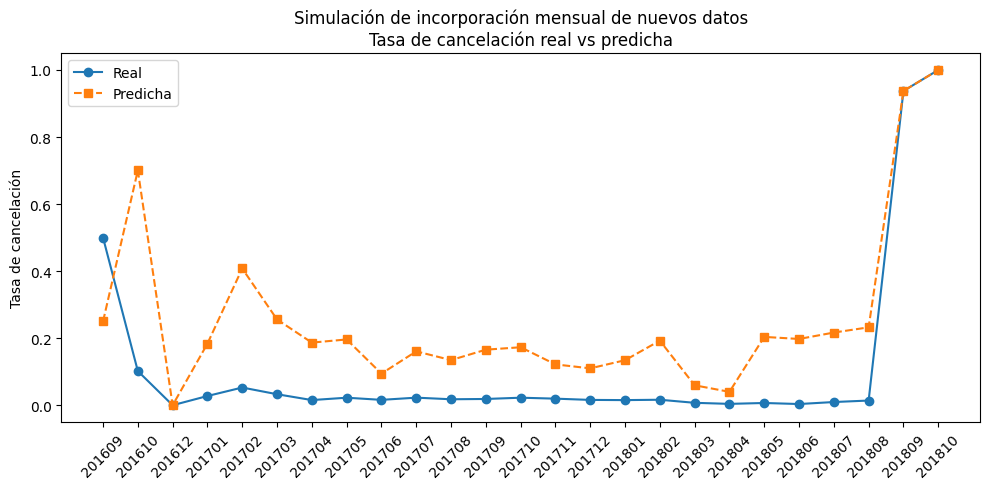

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(monitor_mensual["purchase_ym"], monitor_mensual["cancel_rate_real"], marker="o", label="Real")
plt.plot(monitor_mensual["purchase_ym"], monitor_mensual["cancel_rate_predicha"], marker="s", linestyle="--", label="Predicha")
plt.xticks(rotation=45)
plt.ylabel("Tasa de cancelación")
plt.title("Simulación de incorporación mensual de nuevos datos\nTasa de cancelación real vs predicha")
plt.legend()
plt.tight_layout()
plt.show()
